## *Imports*

Install necessary packages for emotional classifer.

In [5]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Lambda, Layer
from transformers import TFAutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## *Data Preprocessing & Splitting*

In [ ]:
df = pd.read_csv("EmotionDataset/emotions_dataset.csv")

word_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
word_tokenizer.fit_on_texts(df['sentence'])

bert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

sentences = df['sentence'].tolist()
labels = pd.factorize(df['emotion'])[0]

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_word_tokens = word_tokenizer.texts_to_sequences(X_train)
X_test_word_tokens = word_tokenizer.texts_to_sequences(X_test)

X_train_bert_tokens = bert_tokenizer(X_train, padding="max_length", truncation=True, max_length=50, return_tensors="tf")
X_test_bert_tokens = bert_tokenizer(X_test, padding="max_length", truncation=True, max_length=50, return_tensors="tf")

with open("word_tokenizer.pkl", "wb") as f:
    pickle.dump(word_tokenizer, f)

with open("bert_tokenizer.pkl", "wb") as f:
    pickle.dump(bert_tokenizer, f)

print("Word-based tokenization:")
print("X_train shape:", len(X_train_word_tokens))
print("Y_train shape:", len(y_train))
print("X_test shape:", len(X_test_word_tokens))

print("\nBERT-based tokenization:")
print("X_train shape:", X_train_bert_tokens['input_ids'].shape)
print("X_test shape:", X_test_bert_tokens['input_ids'].shape)


Word-based tokenization:
X_train shape: 4935
X_test shape: 1234
Y_train shape: 4935

BERT-based tokenization:
X_train shape: (4935, 50)
X_test shape: (1234, 50)


## *Training High-Parameter Model (BERT-based)*

In [8]:
MODEL_NAME = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = TFAutoModel.from_pretrained(MODEL_NAME)

Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [12]:
MAX_LEN = 50

print("X_train input_ids shape:", X_train_bert_tokens['input_ids'].shape)
print("X_train attention_mask shape:", X_train_bert_tokens['attention_mask'].shape)
print("y_train shape:", len(y_train))

X_train input_ids shape: (4935, 50)
X_train attention_mask shape: (4935, 50)
y_train shape: 4935


In [13]:
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask)
        return bert_output.pooler_output  # Extract CLS token output

input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_output = BertLayer(bert_model)([input_ids, attention_mask])

dense = Dense(128, activation='relu')(bert_output)
output = Dense(len(set(labels)), activation='softmax')(dense)

model_parsbert = Model(inputs=[input_ids, attention_mask], outputs=output)

model_parsbert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_parsbert.fit(
    x=[X_train_bert_tokens['input_ids'], X_train_bert_tokens['attention_mask']], 
    y=np.array(y_train),  # Ensure y_train is a NumPy array
    epochs=5, batch_size=16, 
    validation_data=([X_test_bert_tokens['input_ids'], X_test_bert_tokens['attention_mask']], np.array(y_test))
)


Epoch 1/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 137s 419ms/step - accuracy: 0.5979 - loss: 1.2908 - val_accuracy: 0.8444 - val_loss: 0.4703
Epoch 2/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 125s 404ms/step - accuracy: 0.8681 - loss: 0.4166 - val_accuracy: 0.8501 - val_loss: 0.4301
Epoch 3/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 130s 420ms/step - accuracy: 0.8925 - loss: 0.3258 - val_accuracy: 0.9052 - val_loss: 0.2833
Epoch 4/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 153s 495ms/step - accuracy: 0.9173 - loss: 0.2504 - val_accuracy: 0.9068 - val_loss: 0.2650
Epoch 5/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 156s 504ms/step - accuracy: 0.9310 - loss: 0.2090 - val_accuracy: 0.9230 - val_loss: 0.2403


## *Convert BERT Model to TFLite*

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_parsbert)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_parsbert = converter.convert()

with open("Models/parsbert_emotion_model.tflite", "wb") as f:
    f.write(tflite_parsbert)

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp5wycaj33\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp5wycaj33\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmp5wycaj33'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 50), dtype=tf.int32, name='input_ids'), TensorSpec(shape=(None, 50), dtype=tf.int32, name='attention_mask')]
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  1930404511568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930404510800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411049808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930404511376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411049232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411050000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411049040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411049616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411050384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930411050576

## *Training Lightweight Model (LSTM)*

In [22]:
MAX_SEQ_LENGTH = 50  

X_train_padded = pad_sequences(X_train_word_tokens, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_word_tokens, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=MAX_SEQ_LENGTH),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(16, activation='relu'),
    Dense(len(set(labels)), activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_lstm.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0900 - loss: 2.4850 - val_accuracy: 0.1718 - val_loss: 2.3591
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1664 - loss: 2.2588 - val_accuracy: 0.0843 - val_loss: 2.8878
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0857 - loss: 2.5871 - val_accuracy: 0.0835 - val_loss: 2.4848
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0859 - loss: 2.4856 - val_accuracy: 0.0827 - val_loss: 2.4843
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0948 - loss: 2.4845 - val_accuracy: 0.0891 - val_loss: 2.4849
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0910 - loss: 2.4842 - val_accuracy: 0.0916 - val_loss: 2.4841
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0995 - loss: 2.4845 - val_accuracy: 0.0916 - val_loss: 2.4840
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0964 - loss: 2.4847 - val_accu

## *Convert LSTM Model to TFLite*

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Default TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Allow TensorFlow ops if needed
]
converter._experimental_lower_tensor_list_ops = False
tflite_model_lstm = converter.convert()

# Save the TFLite model
with open("Models/lstm_emotion_model.tflite", "wb") as f:
    f.write(tflite_model_lstm)

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp7hx_1y75\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp7hx_1y75\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmp7hx_1y75'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  1933221622224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221622800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221622992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221623952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221622032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221623568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221624720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933221625680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933263143568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1933263144528

## *Test & Evaluate Models*

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        97
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        95
           5       0.00      0.00      0.00       100
           6       0.09      1.00      0.17       113
           7       0.00      0.00      0.00       104
           8       0.00      0.00      0.00       101
           9       0.00      0.00      0.00       103
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       105

    accuracy                           0.09      1234
   macro avg       0.01      0.08      0.01      1234
weighted avg       0.01      0.09      0.02      1234



C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

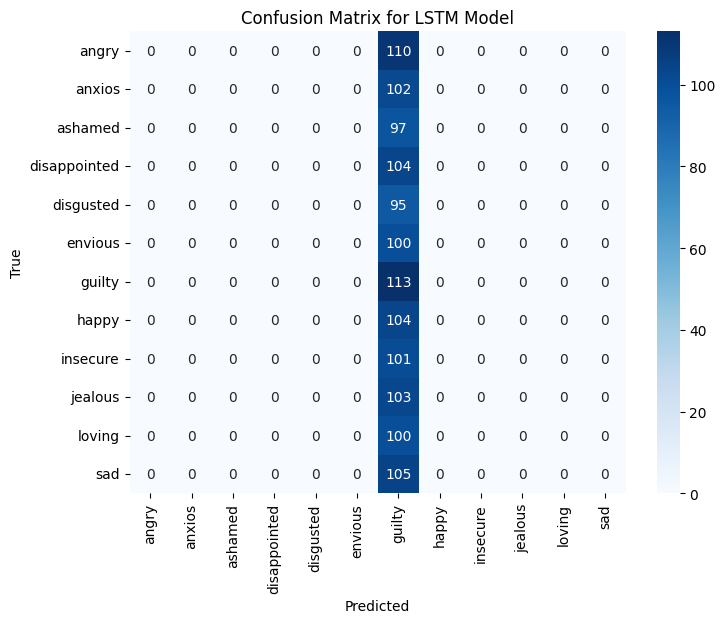

In [27]:
y_pred = np.argmax(model_lstm.predict(X_test_padded), axis=1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['emotion'].unique(), yticklabels=df['emotion'].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for LSTM Model")
plt.show()